In [33]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os

In [34]:
# Importing libraries necessary for Natural Language Processing (NLP)


import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
# nlp = spacy.load("en_core_web_sm")

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [36]:
# Downloading Stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Importing Dataset**

In [37]:
data = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [38]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [40]:
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

<Axes: xlabel='is_there_an_emotion_directed_at_a_brand_or_product', ylabel='count'>

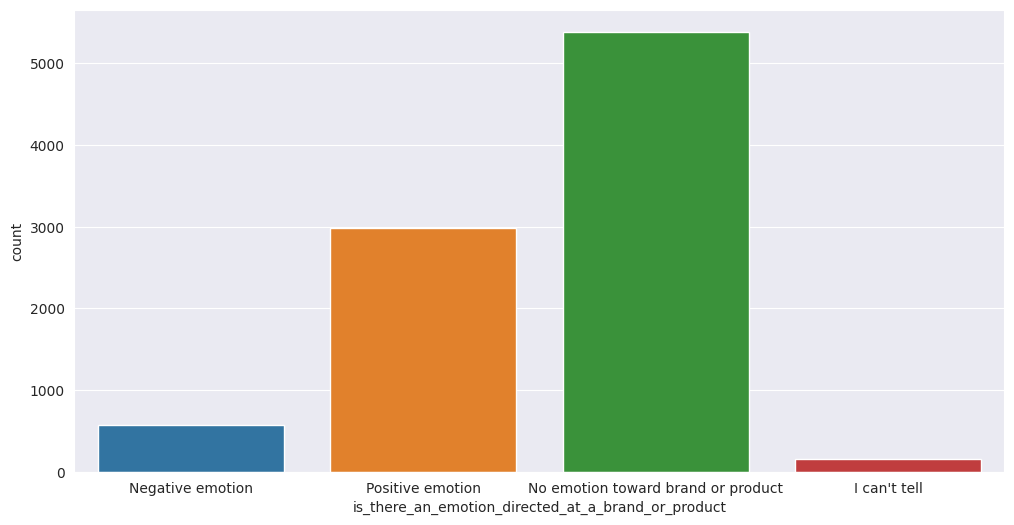

In [41]:
# Viewing the Sentiments of all the tweets in graphical form
# Viewing 'is_there_an_emotion_directed_at_a_brand_or_product' column of dataset

fig =  plt.figure(figsize=(12,6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=data)

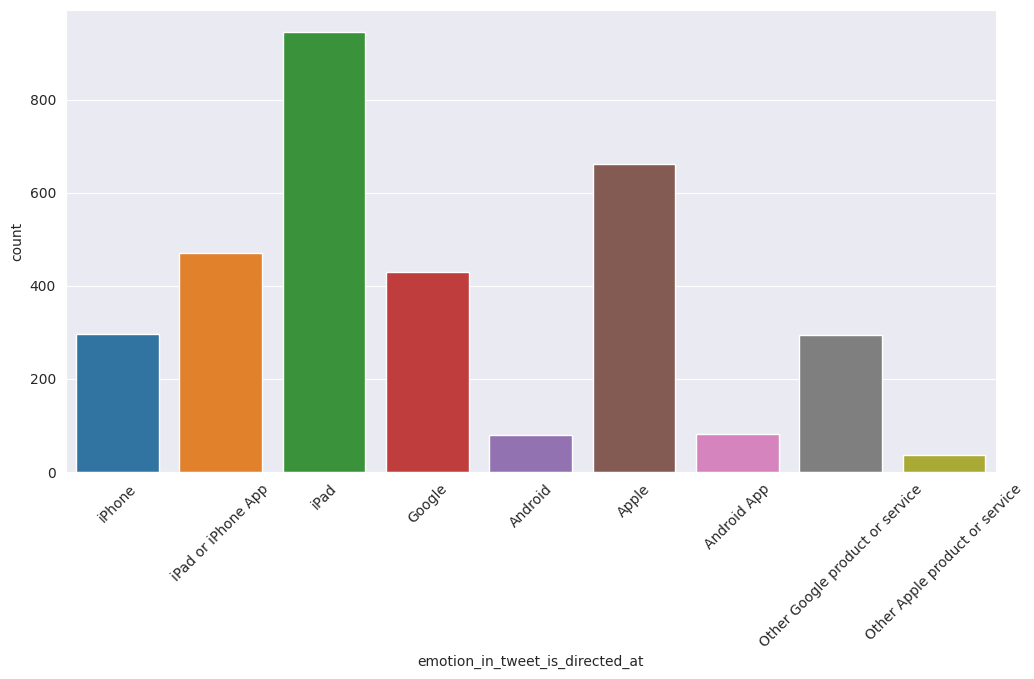

In [42]:
# Viewing the brand at which emotion is aimed at
# Viewing 'emotion_in_tweet_is_directed_at' column of dataset

fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=data)
plt.xticks(rotation=45);

The emotions are aimed at products and services from 2 major companies Apple and Google.

**Data Preparation/Data Pre-Processing**

In [43]:
# Create a working dataframe with easier column name
df = data.copy(deep=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)
df.dropna(subset=['tweet_text'], inplace=True)
df.rename(columns = {'emotion_in_tweet_is_directed_at':'brand_item', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

# Convert the data types to string
df['tweet_text'] = df['tweet_text'].astype(str)
df['brand_item'] = df['brand_item'].astype(str)

# Now we map each product/service to the corresponding brand

brand = {'iPhone': 'apple',
         'iPad or iPhone App':'apple',
         'iPad': 'apple',
         'Google': 'google',
         'nan': 'UNK',
         'Android':'google',
         'Apple': 'apple',
         'Android App':'google',
         'Other Google product or service':'google',
         'Other Apple product or service':'apple'
        }

df['brand_name'] = df['brand_item'].map(brand)

# We will rename classes in 'emotion' to easy to understand ones
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral',
                 "I can't tell":'confused'}

df['emotion'] = df['emotion'].map(label_encoder)
df = df[df['emotion'] != 'confused']    # drop the rows containing 'confused' labels

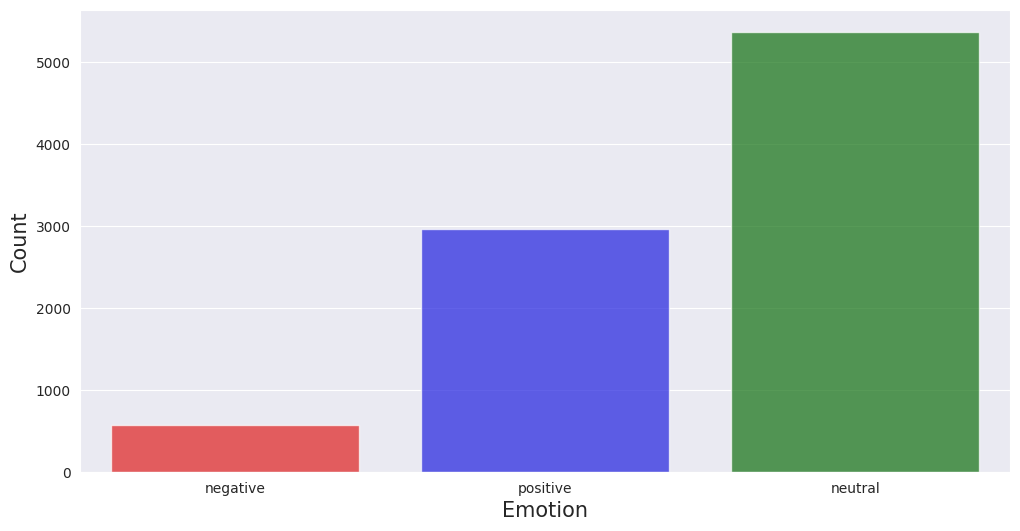

In [44]:
# Plotting the renamed emotions
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15);

In [45]:
df.emotion.value_counts(normalize=True)

neutral     0.602986
positive    0.333146
negative    0.063868
Name: emotion, dtype: float64

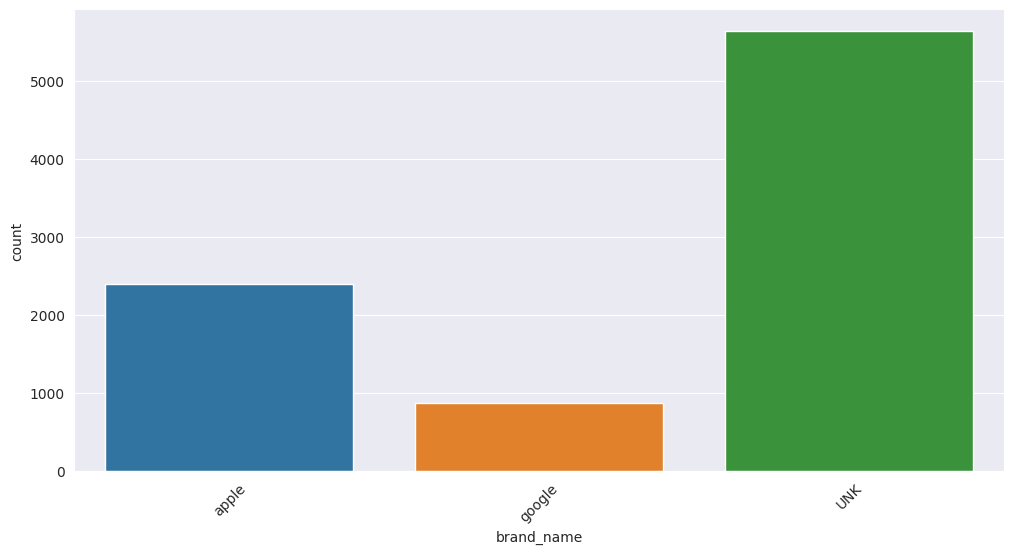

In [46]:
# Plotting number of tweets associated with a particular brand
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='brand_name', data=df)
plt.xticks(rotation=45);

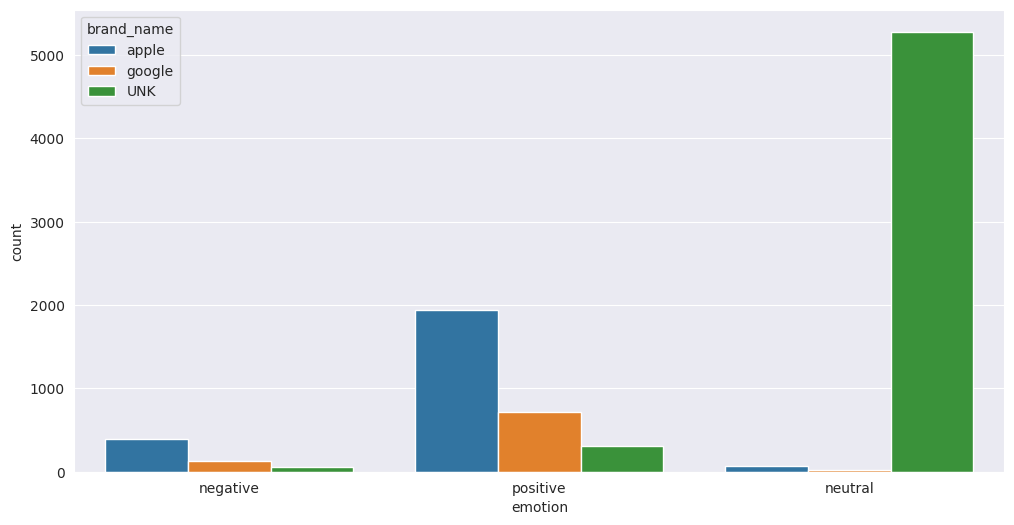

In [47]:
# Plotting 'emotion' and 'brand_name' side by side
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'emotion', hue='brand_name')

**Text Pre-Processing**

In [48]:
# We will need to clean out the unnecessary letters and symbols in the tweet before we start building a model

df.tweet_text.head(10)

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
Name: tweet_text, dtype: object

In [49]:
# Punctuation is a major problem in text analysis and hence has to be dealt with before modelling.
# However it might affect words like " you've, aren't, isn't" etc will change in meaning if the apostrophe is removed. To solve this we map a lot of the commonly used words of this type and add those as exceptions.

contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot",
                   "can't've": "cannot have", "'cause": "because", "could've": "could have",
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not",
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did",
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                   "I'll've": "I will have","I'm": "I am", "I've": "I have",
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                   "i'll've": "i will have","i'm": "i am", "i've": "i have",
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                   "it'll": "it will", "it'll've": "it will have","it's": "it is",
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                   "she's": "she is", "should've": "should have", "shouldn't": "should not",
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is",
                   "there'd": "there would", "there'd've": "there would have","there's": "there is",
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                   "they'll've": "they will have", "they're": "they are", "they've": "they have",
                   "to've": "to have", "wasn't": "was not", "we'd": "we would",
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                   "we're": "we are", "we've": "we have", "weren't": "were not",
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                   "what's": "what is", "what've": "what have", "when's": "when is",
                   "when've": "when have", "where'd": "where did", "where's": "where is",
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                   "who's": "who is", "who've": "who have", "why's": "why is",
                   "why've": "why have", "will've": "will have", "won't": "will not",
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [50]:
# Mapping the exception words to the dataset

def contraction_mapping(text):
    '''
    Function to map contraction to the text.
    '''

    apostrophe_handled = re.sub("’", "'", text)
    expanded = ' '.join([contraction_map[t] if t in contraction_map else t for t in apostrophe_handled.split(" ")])


    return expanded

In [51]:
# Test the function
row = 11
print('Before contraction:', '\n',  df['tweet_text'][row])
print('\nAfter contraction:', '\n', contraction_mapping(df['tweet_text'][row]))

Before contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.

After contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.


In [52]:
# Apply contraction mapping
df['expanded_tweets'] = df['tweet_text'].apply(contraction_mapping)

In [53]:
# Defining a function to remove punctuations, special characters, html links, twitter handles etc

def tweet_cleaner(tweet):

    stopwords = ['rt','rts', 'retweet', 'quot', 'sxsw']

    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x

    x = tweet
    x = re.sub(r'https?:\/\/\S+', '', x) # remove URL references
    x = re.sub(r'{link}', '', x)  # remove placeholders
    x = re.sub(r'@[\w]*', '', x) # remove @mention users
    x = re.sub('[^A-Za-z0-9]+', ' ', x) # remove @mention users
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers
    x = re.sub(r'&[a-z]+;', '', x) # remove HTML reference characters
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    x = x.replace("[^a-zA-z#]", " ")  #remove special characters

    x = [word.lower() for word in x.split() if word.lower() not in stopwords]
    x = [w for w in x if len(w)>2]

    return ' '.join(x)

In [54]:
# Apply the tweet cleaner to whole dataframe
df['clean_tweets1'] = df['expanded_tweets'].apply(tweet_cleaner)

# Word count of all the vocabulary
FreqDist(df['clean_tweets1'].unique().sum().split())

FreqDist({'the': 3253, 'for': 1875, 'ipad': 1653, 'apple': 1457, 'google': 1401, 'and': 1229, 'iphone': 1109, 'store': 1047, 'you': 712, 'new': 678, ...})

We see that the word 'the' is the most commonly used term.While for architecture like LSTM, we might need to retain these kinds of stopwords, but the more simple models like Naive Bayes, we would like to get rid of these words. So, we will create another set of words particularly to train Naive Bayes like algorithms.

In [55]:
def remove_stopwords(tweet):
    stopwords_removed = [word for word in tweet.split() if word not in stopwords.words('english')]
    return ' '.join(stopwords_removed)

In [56]:
# Apply the tweet cleaner to whole dataframe
df['clean_tweets2'] = df['clean_tweets1'].apply(remove_stopwords)

# Word count of all the vocabulary
FreqDist(df['clean_tweets2'].unique().sum().split())

FreqDist({'ipad': 1571, 'apple': 1386, 'google': 1310, 'iphone': 1053, 'store': 1018, 'new': 660, 'austin': 601, 'amp': 595, 'app': 550, 'pop': 452, ...})

In [57]:
df

,tweet_text,brand_item,emotion,brand_name,expanded_tweets,clean_tweets1,clean_tweets2
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,have iphone after hrs tweeting rise austin was...,iphone hrs tweeting rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you wi...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale th...,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple,@sxsw I hope this year's festival is not as cr...,hope this year festival not crashy this year i...,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,positive,apple,Ipad everywhere. #SXSW {link},ipad everywhere,ipad everywhere
9089,"Wave, buzz... RT @mention We interrupt your re...",nan,neutral,UNK,"Wave, buzz... RT @mention We interrupt your re...",wave buzz interrupt your regularly scheduled g...,wave buzz interrupt regularly scheduled geek p...
9090,"Google's Zeiger, a physician never reported po...",nan,neutral,UNK,"Google's Zeiger, a physician never reported po...",google zeiger physician never reported potenti...,google zeiger physician never reported potenti...
9091,Some Verizon iPhone customers complained their...,nan,neutral,UNK,Some Verizon iPhone customers complained their...,some verizon iphone customers complained their...,verizon iphone customers complained time fell ...


In [58]:
# Defining a function for lemmatization. Lemmatization helps in getting the root word from the text with more accuracy and contextual meaning than while performing Stemming

def normalization(tweet):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet.split():
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return ' '.join(normalized_tweet)

In [59]:
# Apply the tweet cleaner to whole dataframe
df['clean_tweets3'] = df['clean_tweets2'].apply(normalization)

# Word count of all the vocabulary
FreqDist(df['clean_tweets3'].unique().sum().split())

FreqDist({'ipad': 1569, 'apple': 1385, 'google': 1308, 'iphone': 1052, 'store': 1046, 'new': 658, 'austin': 601, 'amp': 592, 'app': 549, 'pop': 461, ...})

In [60]:
df

,tweet_text,brand_item,emotion,brand_name,expanded_tweets,clean_tweets1,clean_tweets2,clean_tweets3
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,have iphone after hrs tweeting rise austin was...,iphone hrs tweeting rise austin dead need upgr...,iphone hrs tweet rise austin dead need upgrade...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you wi...,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale th...,wait ipad also sale,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple,@sxsw I hope this year's festival is not as cr...,hope this year festival not crashy this year i...,hope year festival crashy year iphone app,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,positive,apple,Ipad everywhere. #SXSW {link},ipad everywhere,ipad everywhere,ipad everywhere
9089,"Wave, buzz... RT @mention We interrupt your re...",nan,neutral,UNK,"Wave, buzz... RT @mention We interrupt your re...",wave buzz interrupt your regularly scheduled g...,wave buzz interrupt regularly scheduled geek p...,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",nan,neutral,UNK,"Google's Zeiger, a physician never reported po...",google zeiger physician never reported potenti...,google zeiger physician never reported potenti...,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,nan,neutral,UNK,Some Verizon iPhone customers complained their...,some verizon iphone customers complained their...,verizon iphone customers complained time fell ...,verizon iphone customers complain time fell ba...


**Building the Model**

We will test Naive Bayes on tweets with lemmatization

In [61]:
X = df[['clean_tweets3']]
y = df['emotion']

We will take aside 10% of data for Test Set, and further split training data into validation set

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6815, 1), (1203, 1), (891, 1), (6815,), (1203,), (891,))

In [63]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets3']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets3']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets3']).toarray()

In [66]:
# Simple Naive Bayes classifer
clf2_NB = MultinomialNB()
clf2_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [67]:
def get_prediction(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('Training Prediction')
    print('--------------------')
    print(classification_report(y_train, y_train_pred))
    print('Test Prediction')
    print('--------------------')
    print(classification_report(y_test, y_test_pred))

    return y_train_pred, y_test_pred

In [68]:
_, _ = get_prediction(clf2_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.93      0.03      0.06       435
     neutral       0.72      0.98      0.83      4110
    positive       0.90      0.48      0.63      2270

    accuracy                           0.76      6815
   macro avg       0.85      0.50      0.51      6815
weighted avg       0.80      0.76      0.72      6815

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       1.00      0.06      0.12        77
     neutral       0.66      0.93      0.77       725
    positive       0.65      0.28      0.39       401

    accuracy                           0.66      1203
   macro avg       0.77      0.42      0.43      1203
weighted avg       0.68      0.66      0.60      1203



In [69]:
# Instantiate a Random Forest Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6)
clf_rf2.fit(X_train_vec, y_train)

RandomForestClassifier(n_jobs=6, random_state=0)

In [70]:
_, _ = get_prediction(clf_rf2, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95       435
     neutral       0.95      0.98      0.97      4110
    positive       0.97      0.92      0.95      2270

    accuracy                           0.96      6815
   macro avg       0.97      0.94      0.95      6815
weighted avg       0.96      0.96      0.96      6815

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.62      0.23      0.34        77
     neutral       0.70      0.85      0.77       725
    positive       0.63      0.47      0.54       401

    accuracy                           0.68      1203
   macro avg       0.65      0.52      0.55      1203
weighted avg       0.67      0.68      0.66      1203



**Neural Networks**

In [71]:
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [72]:
# One-Hot Encoding
# Our label class needs to be one-hot encoded before proceeding

X = df['clean_tweets1']
y_ohe = pd.get_dummies(df['emotion'])
print(X.iloc[:3], y_ohe.iloc[:3])

0    have iphone after hrs tweeting rise austin was...
1    know about awesome ipad iphone app that you wi...
2    can not wait for ipad also they should sale th...
Name: clean_tweets1, dtype: object    negative  neutral  positive
0         1        0         0
1         0        0         1
2         0        0         1


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.10, stratify=y_ohe,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6815,), (1203,), (891,), (6815, 3), (1203, 3), (891, 3))

**Tokenization**

In [74]:
def create_tokens(X_train, X_val, X_test):
    '''
    A simple function to create word tokens with padded sequences
    '''
    tokenizer = Tokenizer(oov_token=True)
    tokenizer.fit_on_texts(X_train)

    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_val_token = tokenizer.texts_to_sequences(X_val)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = len(max(X_train_token, key=lambda x: len(x)))
    maxlen_orig= len(max(X_train, key=lambda x: len(x)))

    X_train_seq = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
    X_test_seq = pad_sequences(X_test_token, padding='post', maxlen=maxlen)
    X_val_seq = pad_sequences(X_val_token, padding='post', maxlen=maxlen)

    print(f"Token count: {tokenizer.document_count}, Vocab size: {vocab_size}, Max lenth: {maxlen}, Original length: {maxlen_orig}")

    return X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer

In [75]:
X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer = create_tokens(X_train, X_val, X_test)

Token count: 6815, Vocab size: 8071, Max lenth: 23, Original length: 129


**LSTM Model**

In [76]:
# Helper function: Define callbacks and save final model

def predict(model, epochs, batch_size):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model/cp.ckpt', monitor='val_loss',
                             save_weights_only = True,
                             save_best_only=True)]

    history = model.fit(X_train_seq, y_train,
                     batch_size=batch_size, epochs=epochs, verbose=1,
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                       )

#     graph_model(history, 'loss')
#     graph_model(history, 'accuracy')

    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)

    return history, train_prediction, val_prediction, test_prediction,

In [77]:
def graph_model(history, metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+ metrics])
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend(['training', 'test'], loc='upper right')
    plt.show()

In [78]:
# Training a simple LSTM model

embed_dim=128

model_lstm1 = Sequential()
model_lstm1.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 100,
                    input_length = maxlen))
model_lstm1.add(layers.LSTM(embed_dim, return_sequences=True))
model_lstm1.add(layers.GlobalMaxPool1D())
model_lstm1.add(layers.Dropout(0.2))
model_lstm1.add(layers.Dense(64, activation='relu'))
model_lstm1.add(layers.Dense(3, activation='softmax'))

model_lstm1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           807100    
                                                                 
 lstm (LSTM)                 (None, 23, 128)           117248    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [79]:
history_lstm1, _, _, _ = predict(model_lstm1, 20, 32)

Epoch 1/20
213/213 [==============================] - 15s 58ms/step - loss: 0.8227 - accuracy: 0.6197 - val_loss: 0.7729 - val_accuracy: 0.6633
Epoch 2/20
213/213 [==============================] - 18s 86ms/step - loss: 0.6487 - accuracy: 0.7272 - val_loss: 0.7468 - val_accuracy: 0.6692
Epoch 3/20
213/213 [==============================] - 19s 90ms/step - loss: 0.4768 - accuracy: 0.8123 - val_loss: 0.7698 - val_accuracy: 0.6692
Epoch 4/20
213/213 [==============================] - 12s 57ms/step - loss: 0.3579 - accuracy: 0.8521 - val_loss: 0.9491 - val_accuracy: 0.6600
Epoch 5/20
213/213 [==============================] - 12s 58ms/step - loss: 0.2886 - accuracy: 0.8861 - val_loss: 1.1062 - val_accuracy: 0.6617
Epoch 6/20
213/213 [==============================] - 19s 91ms/step - loss: 0.2428 - accuracy: 0.8971 - val_loss: 1.0524 - val_accuracy: 0.6625
Epoch 7/20
28/28 [==============================] - 0s 13ms/step


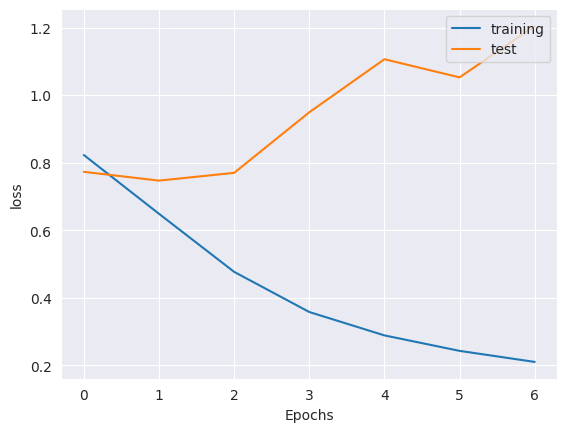

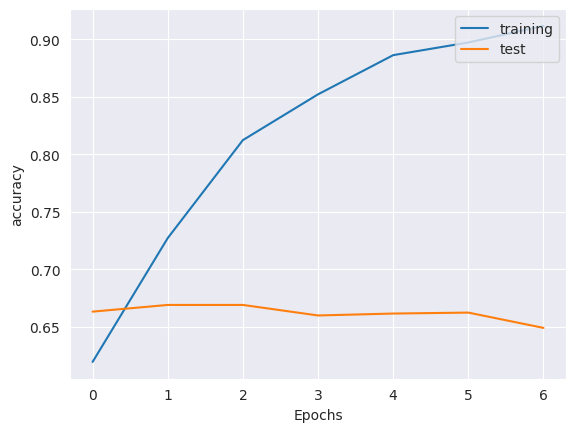

In [80]:
graph_model(history_lstm1, 'loss')
graph_model(history_lstm1, 'accuracy')

We can see our LSTM model hugely suffers from overfitting problem. Futhermore, current validation accuracy is on the same level as classical model such as Naive Bayes or Random Forest.

**GRU Model**

In [83]:
# Create a weight matrix for work vocabulary from our training set

embeddings_index = {}                   # We chose 100-dimensional version, so the Embedding layer must be defined with output_dim set to 100
embedding_matrix = np.zeros((vocab_size, 100))  # 100 for 100-dimensional version
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 8070/8070 [00:00<00:00, 779136.65it/s]


In [84]:
# GRU model is a better fit for smaller datasets

model_gru1 = Sequential()
model_gru1.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix],
                     input_length=maxlen, trainable=False))
model_gru1.add(layers.Dropout(0.4))
model_gru1.add(layers.GRU(100))
model_gru1.add(layers.Flatten())
model_gru1.add(layers.Dropout(0.2))
model_gru1.add(layers.Dense(64, activation='relu'))
model_gru1.add(layers.Dense(3, activation='softmax'))

model_gru1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 100)           807100    
                                                                 
 dropout_1 (Dropout)         (None, 23, 100)           0         
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dense_3 (Dense)             (None, 3)                

In [85]:
hist_gru1, train_gru1, val_gru1, test_gru1 = predict(model_gru1, 20, 32)

Epoch 1/20
213/213 [==============================] - 7s 23ms/step - loss: 1.0494 - accuracy: 0.6007 - val_loss: 1.0064 - val_accuracy: 0.6027
Epoch 2/20
213/213 [==============================] - 6s 28ms/step - loss: 0.9746 - accuracy: 0.6031 - val_loss: 0.9471 - val_accuracy: 0.6027
Epoch 3/20
213/213 [==============================] - 4s 21ms/step - loss: 0.9268 - accuracy: 0.6031 - val_loss: 0.9099 - val_accuracy: 0.6027
Epoch 4/20
213/213 [==============================] - 5s 21ms/step - loss: 0.8970 - accuracy: 0.6031 - val_loss: 0.8866 - val_accuracy: 0.6027
Epoch 5/20
213/213 [==============================] - 6s 28ms/step - loss: 0.8786 - accuracy: 0.6031 - val_loss: 0.8721 - val_accuracy: 0.6027
Epoch 6/20
213/213 [==============================] - 4s 21ms/step - loss: 0.8670 - accuracy: 0.6031 - val_loss: 0.8631 - val_accuracy: 0.6027
Epoch 7/20
213/213 [==============================] - 5s 21ms/step - loss: 0.8596 - accuracy: 0.6031 - val_loss: 0.8573 - val_accuracy: 0.6027

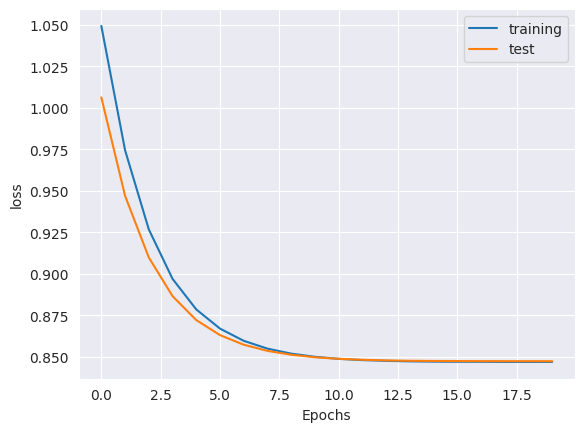

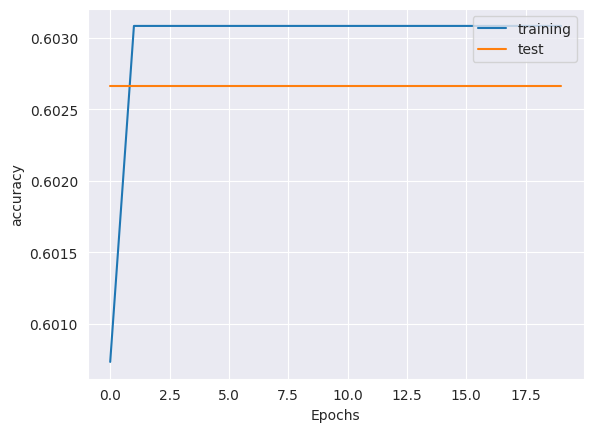

In [86]:
graph_model(hist_gru1, 'loss')
graph_model(hist_gru1, 'accuracy')

In [87]:
def predict_df(y_true, y_pred):
    '''
    A simple function to put predicted results into a dataframe
    '''

    true_df = pd.DataFrame(y_true.idxmax(axis=1), columns=['true_emotion']).reset_index(drop=True)

    pred_df = pd.DataFrame(y_pred.argmax(axis=1), columns=['predicted'])
    pred_df['predicted'] = pred_df['predicted'].apply(lambda x: 'negative' if x==0
                                                     else 'neutral' if x==1
                                                     else 'positive' )

    merge_df = pd.merge(true_df, pred_df, left_index=True, right_index=True)

    print(classification_report(merge_df['true_emotion'], merge_df['predicted']))

    return merge_df

In [88]:
train_predict_df = predict_df(y_train, train_gru1)
val_predict_df = predict_df(y_val, val_gru1)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       435
     neutral       0.60      1.00      0.75      4110
    positive       0.00      0.00      0.00      2270

    accuracy                           0.60      6815
   macro avg       0.20      0.33      0.25      6815
weighted avg       0.36      0.60      0.45      6815

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        77
     neutral       0.60      1.00      0.75       725
    positive       0.00      0.00      0.00       401

    accuracy                           0.60      1203
   macro avg       0.20      0.33      0.25      1203
weighted avg       0.36      0.60      0.45      1203



From the graphs we confer that the GRU model built is more well fit for the dataset in comparison to LSTM Model that we built earlier

**Building the finalised Model**

In [89]:
def create_model(vocab_size, maxlen, embed_dim):
  model = Sequential()
  model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                             weights=[embedding_matrix],
                             input_length=maxlen, trainable=False))
  model.add(layers.Dropout(0.4))
  model.add(layers.GRU(100))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [90]:
final_model = create_model(vocab_size, maxlen, embed_dim=128)
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           807100    
                                                                 
 dropout_3 (Dropout)         (None, 23, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 dense_5 (Dense)             (None, 3)                

**Fitting the Model**

In [91]:
checkpoint_path = 'final_model_weights/cp.{epoch:04d}.ckpt'

# Create a Model Check point
checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

history_final = final_model.fit(X_train_seq, y_train,
                          batch_size=32,
                          epochs=20,
                          verbose=1,
                          validation_data=(X_val_seq, y_val),
                          callbacks= [checkpoint]
                         )
train_prediction = final_model.predict(X_train_seq, batch_size=32)
val_prediction = final_model.predict(X_val_seq, batch_size=32)
test_prediction = final_model.predict(X_test_seq, batch_size=32)

Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 1.0491 - accuracy: 0.6004
Epoch 1: val_loss improved from inf to 1.00630, saving model to final_model_weights/cp.0001.ckpt
213/213 [==============================] - 9s 30ms/step - loss: 1.0491 - accuracy: 0.6004 - val_loss: 1.0063 - val_accuracy: 0.6027
Epoch 2/20
211/213 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.6044
Epoch 2: val_loss improved from 1.00630 to 0.94665, saving model to final_model_weights/cp.0002.ckpt
213/213 [==============================] - 4s 21ms/step - loss: 0.9742 - accuracy: 0.6031 - val_loss: 0.9466 - val_accuracy: 0.6027
Epoch 3/20
212/213 [============================>.] - ETA: 0s - loss: 0.9263 - accuracy: 0.6036
Epoch 3: val_loss improved from 0.94665 to 0.90953, saving model to final_model_weights/cp.0003.ckpt
213/213 [==============================] - 4s 21ms/step - loss: 0.9266 - accuracy: 0.6031 - val_loss: 0.9095 - val_accuracy: 0.6027
Epoch 4/20
212/21

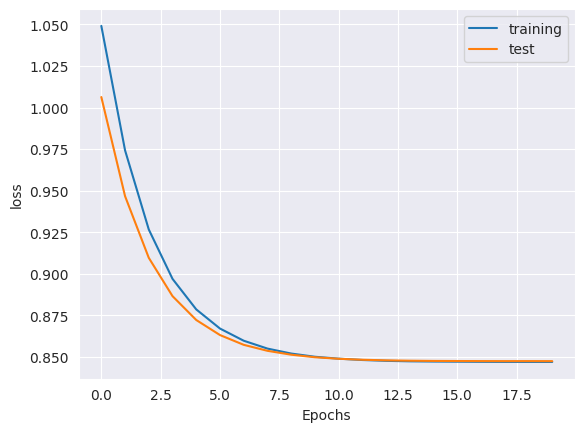

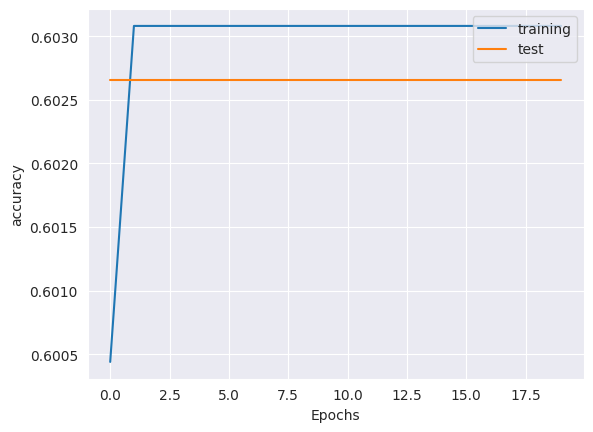

In [92]:
graph_model(history_final, 'loss')
graph_model(history_final, 'accuracy')

In [93]:
# Look inside save folder.
# sorted(os.listdir('final_model_weights'))

**Predictions**

In [94]:
def evaluate_nn(model, X_test, y_test):
    """Print model accuracy on test set."""

    loss, acc = model.evaluate(X_test, y_test)
    print(f'Model Accuracy:\n\t{round(acc, 3)}')


# Evaluate model
evaluate_nn(final_model, X_test_seq, y_test)

28/28 [==============================] - 0s 8ms/step - loss: 0.8473 - accuracy: 0.6027
Model Accuracy:
	0.603


In [95]:
test_prediction = final_model.predict(X_test_seq, batch_size=32)

28/28 [==============================] - 0s 7ms/step


In [96]:
test_predict_df = predict_df(y_test, test_prediction)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        57
     neutral       0.60      1.00      0.75       537
    positive       0.00      0.00      0.00       297

    accuracy                           0.60       891
   macro avg       0.20      0.33      0.25       891
weighted avg       0.36      0.60      0.45       891



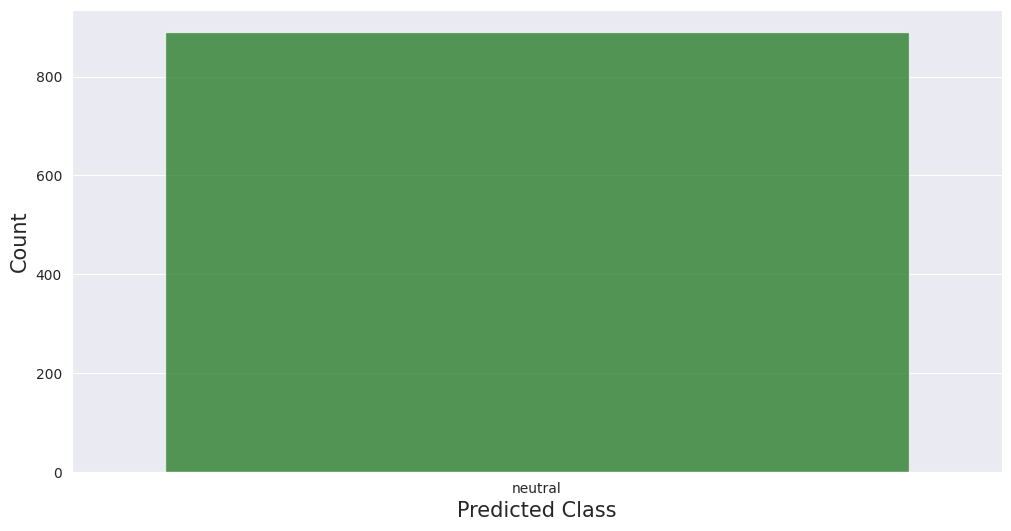

In [97]:
# Predicted Class of Emotions shown Graphically

fig = plt.figure(figsize=(12,6))
colors = ['b']
sns.countplot(x='predicted', data=test_predict_df,
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Count", fontsize=15);

In [100]:
# Examples of Test Prediction
X_test_orig = X_test.copy(deep=True)
X_test_orig.reset_index(drop=True, inplace=True)
X_test_orig = pd.DataFrame(X_test_orig.values, columns=['tweet'])
X_test_pred_merge = pd.merge(X_test_orig, test_predict_df, left_index=True, right_index=True)
X_test_pred_merge.head()

,tweet,true_emotion,predicted
0,sweet apple listened temp apple store near for...,positive,neutral
1,for everyone here map favorite places austin,neutral,neutral
2,less than half hour and will tell you how win ...,neutral,neutral
3,austin conference google search they have inte...,neutral,neutral
4,yes there line front the all but confirmed pop...,neutral,neutral


In [101]:
print(X_test_pred_merge['tweet'][5])
print(X_test_pred_merge['true_emotion'][5])
print(X_test_pred_merge['predicted'][5])

woot just won the google lego hackathon competition startupbus cle
positive
neutral


In [102]:
print(X_test_pred_merge['tweet'][100])
print(X_test_pred_merge['true_emotion'][100])
print(X_test_pred_merge['predicted'][100])

agencies push google directions they never would have gone otherwise says creative lab strategy director
neutral
neutral


In [104]:
print(X_test_pred_merge['tweet'][700])
print(X_test_pred_merge['true_emotion'][700])
print(X_test_pred_merge['predicted'][700])

one more time with feeling android developer meetup saturday 30pm sat hilton 615ab all welcome you might
neutral
neutral


In [105]:
X_test_pred_merge.head()

,tweet,true_emotion,predicted
0,sweet apple listened temp apple store near for...,positive,neutral
1,for everyone here map favorite places austin,neutral,neutral
2,less than half hour and will tell you how win ...,neutral,neutral
3,austin conference google search they have inte...,neutral,neutral
4,yes there line front the all but confirmed pop...,neutral,neutral


In [106]:
from wordcloud import WordCloud

In [107]:
def create_wordcloud(df, col):
    wordcloud = WordCloud(background_color='black').generate(str(col))
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.show()

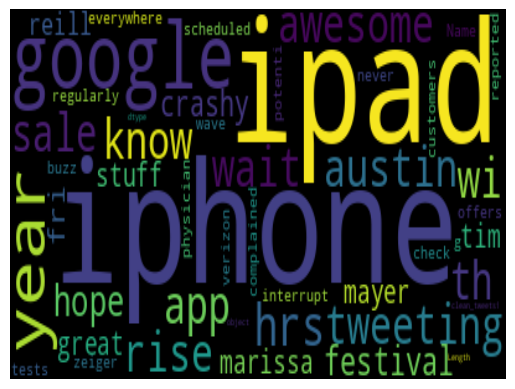

In [108]:
create_wordcloud(df.loc[df['emotion']=='negative'], df['clean_tweets1'])  # 'Negative Emotion'

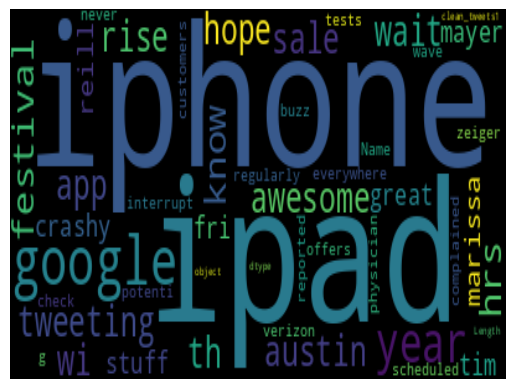

In [109]:
create_wordcloud(df.loc[df['emotion']=='positive'], df['clean_tweets1'])  # 'Positive Emotion'

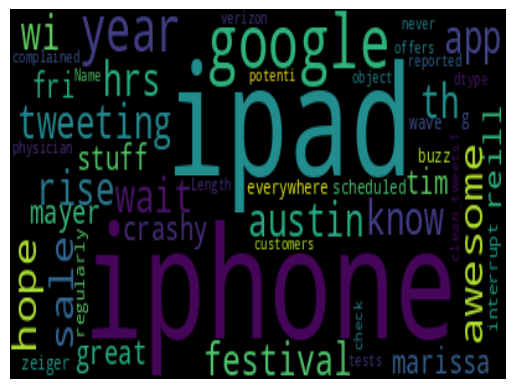

In [110]:
create_wordcloud(df.loc[df['emotion']=='neutral'], df['clean_tweets1'])    # 'Neutral Emotion'